In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf 

from tensorflow.keras.layers import Embedding, Input, Flatten, Multiply, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [2]:
# load dataset
rating_df = pd.read_csv('./data/ml-latest-small/ratings.csv')

In [3]:
# preprocessing
moive_enc = LabelEncoder()
rating_df['movieId'] = moive_enc.fit_transform(rating_df['movieId'])

n_users = rating_df.userId.nunique()
n_movies = rating_df.movieId.nunique()

In [4]:
# implicit feedback 
rating_df['rating'] = [1 if x>=4 else 0 for x in rating_df['rating']]
rating_df

,userId,movieId,rating,timestamp
0,1,0,1,964982703
1,1,2,1,964981247
2,1,5,1,964982224
3,1,43,1,964983815
4,1,46,1,964982931
...,...,...,...,...
100831,610,9416,1,1493848402
100832,610,9443,1,1493850091
100833,610,9444,1,1494273047
100834,610,9445,1,1493846352


In [5]:
# model hyperparameters
latent_dim_gmf = 64
latent_dim_mlp = 64
num_hidden_layers = 5

In [6]:
# input layers
user_input = Input(shape=(1, ), dtype='int32', name='user_input')
movie_input = Input(shape=(1, ), dtype='int32', name='movie_input')

In [7]:
# embedding layers
embedding_user_gmf = Embedding(input_dim=n_users, output_dim=latent_dim_gmf,
                               name='user_embedding_gmf', input_length=1)(user_input)
embedding_movie_gmf = Embedding(input_dim=n_movies, output_dim=latent_dim_gmf,
                               name='movie_embedding_gmf', input_length=1)(movie_input)

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
embedding_user_mlp = Embedding(input_dim=n_users, output_dim=latent_dim_mlp,
                               name='user_embedding_mlp', input_length=1)(user_input)
embedding_movie_mlp = Embedding(input_dim=n_movies, output_dim=latent_dim_mlp,
                                name='movie_embedding_mlp', input_length=1)(movie_input)

In [9]:
# flatten embeddings
user_latent_gmf = Flatten()(embedding_user_gmf)
movie_latent_gmf = Flatten()(embedding_movie_gmf)
user_latent_mlp = Flatten()(embedding_user_mlp)
movie_latent_mlp = Flatten()(embedding_movie_mlp)

In [10]:
# GMF part
gmf_vector = Multiply()([user_latent_gmf, movie_latent_gmf])

In [11]:
# MLP part
concat_vector_mlp = Concatenate()([user_latent_mlp, movie_latent_mlp])
mlp_vector = Dense(64, activation='relu')(concat_vector_mlp)

for _ in range(num_hidden_layers - 1):
    mlp_vector = Dense(64, activation='relu')(mlp_vector)

In [12]:
# NeuMF part
nuemf_vector = Concatenate()([gmf_vector, mlp_vector])
output = Dense(1, activation='sigmoid')(nuemf_vector)

In [13]:
model = Model([user_input, movie_input], output)
# compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

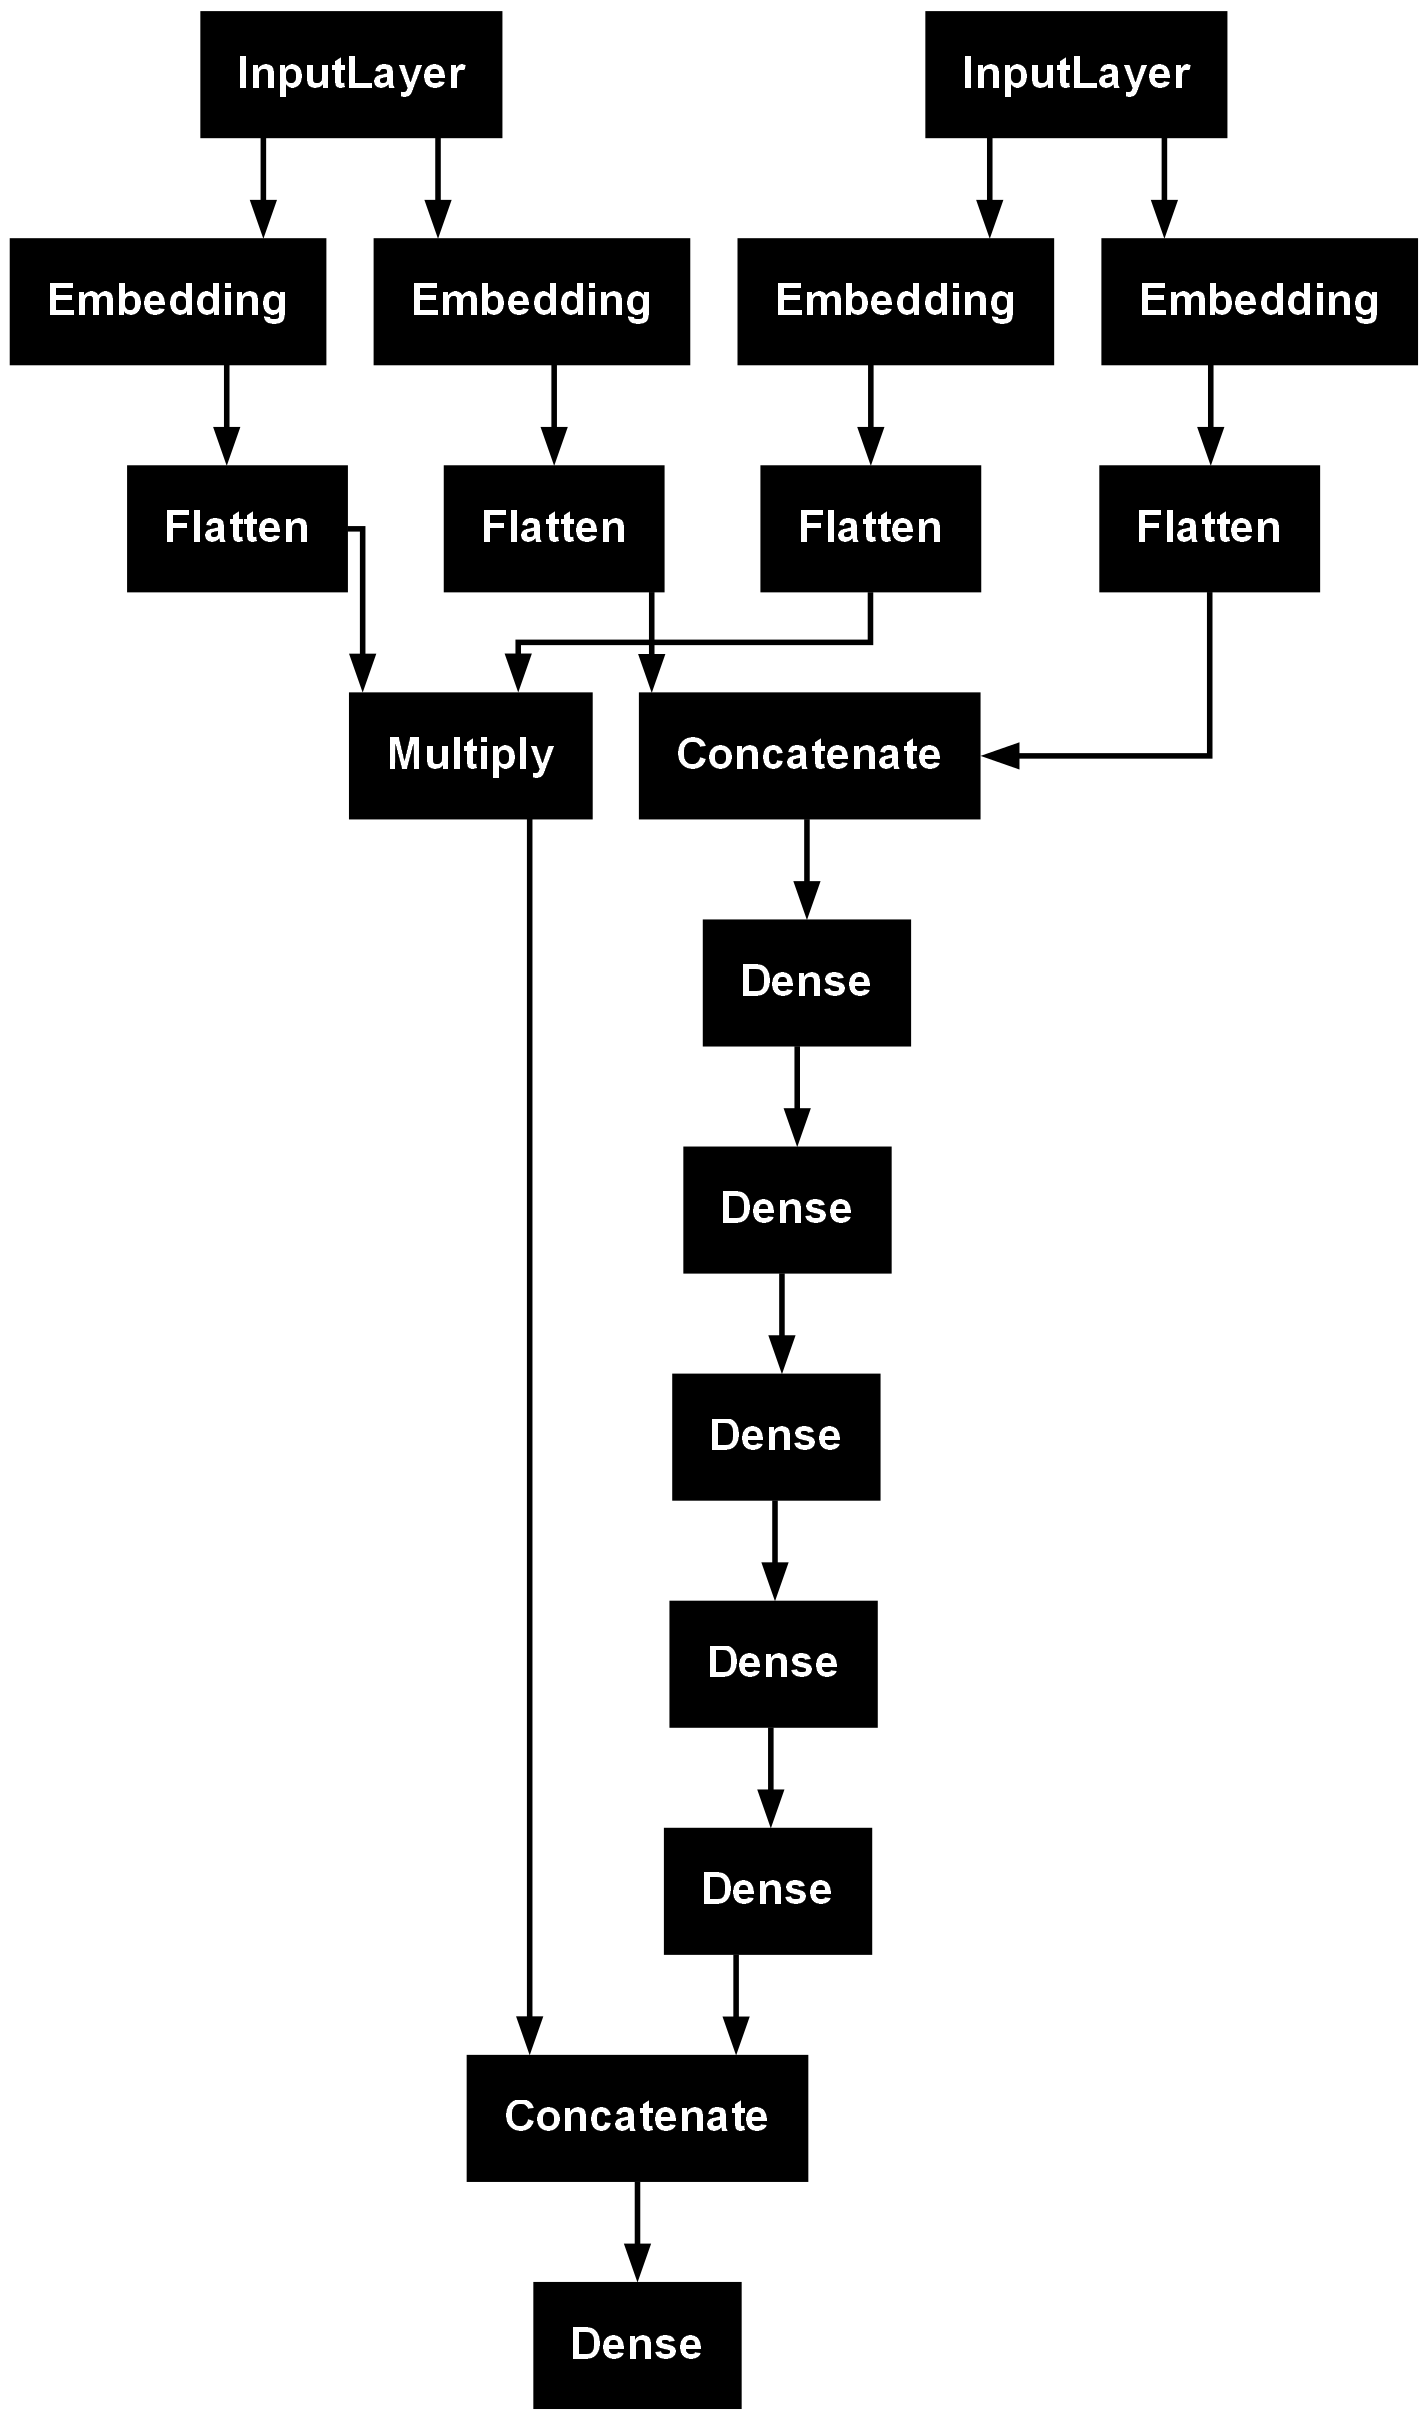

In [14]:
tf.keras.utils.plot_model(model)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_mlp  │ (None, 1, 64)     │     39,040 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding_mlp │ (None, 1, 64)     │    622,336 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 64)        │          0 │ user_embedding_m… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 64)        │          0 │ movie_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_gmf  │ (None, 1, 64)     │     39,040 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding_gmf │ (None, 1, 64)     │    622,336 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ user_embedding_g… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ movie_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,347,777 (5.14 MB)

 Trainable params: 1,347,777 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# reindexing for starting from 0
user_input = rating_df['userId'].values - 1
movie_input = rating_df['movieId'].values 
labels = rating_df['rating'].values

In [17]:
# train test split
user_input_train, user_input_test, movie_input_train, movie_input_test, y_train, y_test = train_test_split(user_input, movie_input, labels, test_size=0.2, random_state=42) 

In [18]:
# fit the model
history = model.fit([user_input_train, movie_input_train], y_train,
                    validation_data=([user_input_test, movie_input_test], y_test),
                    epochs=5, verbose=1)

# prediction
y_pred = model.predict([user_input_test, movie_input_test])

# AUC score
auc_score = roc_auc_score(y_test, y_pred)
print(f"The AUC score is {auc_score}")

Epoch 1/5


d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'movie_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc: 0.7127 - loss: 0.6125 - val_auc: 0.7844 - val_loss: 0.5595
Epoch 2/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.8472 - loss: 0.4855 - val_auc: 0.7869 - val_loss: 0.5677
Epoch 3/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.9742 - loss: 0.2498 - val_auc: 0.7511 - val_loss: 0.6451
Epoch 4/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.9972 - loss: 0.1024 - val_auc: 0.7512 - val_loss: 0.7713
Epoch 5/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.9998 - loss: 0.0419 - val_auc: 0.7497 - val_loss: 0.9319
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
The AUC score is 0.751114619759542


In [19]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_neumf_model(n_users, n_movies, latent_dim_gmf=64, latent_dim_mlp=64, num_hidden_layers=5, dropout_rate=0.2):
    # input layers
    user_input = Input(shape=(1, ), dtype='int32', name='user_input')
    movie_input = Input(shape=(1, ), dtype='int32', name='movie_input')
    
    # embedding layers
    embedding_user_gmf = Embedding(input_dim=n_users, output_dim=latent_dim_gmf, name='user_embedding_gmf', input_length=1)(user_input)
    embedding_movie_gmf = Embedding(input_dim=n_movies, output_dim=latent_dim_gmf, name='movie_embedding_gmf', input_length=1)(movie_input)
    embedding_user_mlp = Embedding(input_dim=n_users, output_dim=latent_dim_mlp, name='user_embedding_mlp', input_length=1)(user_input)
    embedding_movie_mlp = Embedding(input_dim=n_movies, output_dim=latent_dim_mlp, name='movie_embedding_mlp', input_length=1)(movie_input)
    
    # Flatten embeddings
    user_latent_gmf = Flatten()(embedding_user_gmf)
    movie_latent_gmf = Flatten()(embedding_movie_gmf)
    user_latent_mlp = Flatten()(embedding_user_mlp)
    movie_latent_mlp = Flatten()(embedding_movie_mlp)
    
    # GMV Part
    gmf_vector = Multiply()([user_latent_gmf, movie_latent_gmf])
    
    # MLP Part
    concat_vector_mlp = Concatenate()([user_latent_mlp, movie_latent_mlp])
    mlp_vector = Dense(64, activation='relu')(concat_vector_mlp)
    mlp_vector = Dropout(dropout_rate)(mlp_vector)
    
    for _ in range(num_hidden_layers - 1):
        mlp_vector = Dense(64, activation='relu')(mlp_vector)
        mlp_vector = Dropout(dropout_rate)(mlp_vector)
        
    # NeuMF Part
    neumf_vector = Concatenate()([gmf_vector, mlp_vector])
    output = Dense(1, activation='sigmoid')(neumf_vector)
    
    model = Model([user_input, movie_input], output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    
    return model

In [20]:
model = create_neumf_model(n_users, n_movies, latent_dim_gmf=16, latent_dim_mlp=16, num_hidden_layers=5, dropout_rate=0.2)
early_stopping = EarlyStopping(monitor='val_loss', patience=1)
history = model.fit([user_input_train, movie_input_train], y_train,
                    validation_data=([user_input_test, movie_input_test], y_test),
                    epochs=2, verbose=1, callbacks=[early_stopping])

Epoch 1/2


d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'movie_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - auc: 0.6892 - loss: 0.6267 - val_auc: 0.7853 - val_loss: 0.5615
Epoch 2/2
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - auc: 0.8220 - loss: 0.5190 - val_auc: 0.7884 - val_loss: 0.5554


In [21]:
import os
from tensorflow.keras.callbacks import TensorBoard

# define the hyperparameters
latent_dim_gmf_values = [16, 32]
latent_dim_mlp_values = [16, 32]
num_hidden_layer_values = [1, 2]

# log 
log_dir = './logs/'
os.makedirs(log_dir, exist_ok=True)

# iterate
for latent_dim_gmf in latent_dim_gmf_values:
    for latent_dim_mlp in latent_dim_mlp_values:
        for num_hidden_layres in num_hidden_layer_values:
            
            hyperparameters_dir = os.path.join(log_dir, f'gmf_{latent_dim_gmf}_mlp_{latent_dim_mlp}_layers_{num_hidden_layers}')
            os.makedirs(hyperparameters_dir, exist_ok=True)
            tensorboard_callback = TensorBoard(log_dir=hyperparameters_dir)
            
            model = create_neumf_model(n_users, n_movies, latent_dim_gmf=latent_dim_gmf, latent_dim_mlp=latent_dim_mlp,
                                       num_hidden_layers=num_hidden_layers, dropout_rate=0.2)
            
            # fit the model
            history = model.fit([user_input_train, movie_input_train], y_train,
                                validation_data=([user_input_test, movie_input_test], y_test),
                                epochs=5, verbose=1, callbacks=[early_stopping, tensorboard_callback])

Epoch 1/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - auc: 0.7035 - loss: 0.6202 - val_auc: 0.7834 - val_loss: 0.5621
Epoch 2/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - auc: 0.8205 - loss: 0.5199 - val_auc: 0.7860 - val_loss: 0.5565
Epoch 1/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - auc: 0.6920 - loss: 0.6263 - val_auc: 0.7827 - val_loss: 0.5595
Epoch 2/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - auc: 0.8206 - loss: 0.5198 - val_auc: 0.7886 - val_loss: 0.5574
Epoch 1/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.6938 - loss: 0.6255 - val_auc: 0.7838 - val_loss: 0.5609
Epoch 2/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - auc: 0.8214 - loss: 0.5191 - val_auc: 0.7860 - val_loss: 0.5571
Epoch 1/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - auc: 0.7031 - loss: 0.6208 - val_auc: 0.7848 - val_loss: 0.5576
Epoch 2/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - auc: 0.8225 - loss: 0.5174 - val_auc: 0.7875 - val_loss: 0.5605
Epoch 1/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/

In [22]:
%load_ext tensorboard 
%tensorboard --logdir /logs